In [1]:
#加载全部数据到内存中
def get_data():
    from datasets import load_dataset
    import numpy as np

    #加载
    dataset = load_dataset('lansinuote/gen.1.celeba', split='train')

    #采样
    dataset = dataset.shuffle(0).select(range(2000))

    #图片转数据
    def f(data):
        images = data['image']

        data = []
        for i in images:
            i = i.resize((224, 224))
            i = np.array(i)
            i = i / 255
            i = i.transpose(2, 0, 1)
            data.append(i)
        return {'image': data}

    dataset = dataset.map(function=f,
                          batched=True,
                          batch_size=1000,
                          num_proc=4,
                          remove_columns=list(dataset.features)[1:])

    #加载为numpy数据
    data = np.empty((2000, 3, 224, 224), dtype=np.float32)
    for i in range(len(dataset)):
        data[i] = dataset[i]['image']

    return data


data = get_data()

data.shape, data.min(), data.max()

Using custom data configuration lansinuote--gen.1.celeba-cdea5a503bf57939
Found cached dataset parquet (/root/.cache/huggingface/datasets/lansinuote___parquet/lansinuote--gen.1.celeba-cdea5a503bf57939/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)
Loading cached shuffled indices for dataset at /root/.cache/huggingface/datasets/lansinuote___parquet/lansinuote--gen.1.celeba-cdea5a503bf57939/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec/cache-5eb78bab229fe5c7.arrow


Loading cached processed dataset at /root/.cache/huggingface/datasets/lansinuote___parquet/lansinuote--gen.1.celeba-cdea5a503bf57939/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec/cache-35e73965b2bd3140.arrow


Loading cached processed dataset at /root/.cache/huggingface/datasets/lansinuote___parquet/lansinuote--gen.1.celeba-cdea5a503bf57939/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec/cache-c3d90abc313386ca.arrow


Loading cached processed dataset at /root/.cache/huggingface/datasets/lansinuote___parquet/lansinuote--gen.1.celeba-cdea5a503bf57939/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec/cache-c3ad9360e2a6c1b3.arrow


Loading cached processed dataset at /root/.cache/huggingface/datasets/lansinuote___parquet/lansinuote--gen.1.celeba-cdea5a503bf57939/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec/cache-a167ba90e004ddc2.arrow


((2000, 3, 224, 224), 0.0, 1.0)

In [2]:
import torch

loader = torch.utils.data.DataLoader(dataset=data,
                                     batch_size=4,
                                     shuffle=True,
                                     drop_last=True)

len(loader), next(iter(loader)).shape

(500, torch.Size([4, 3, 224, 224]))

In [3]:
def show(images):
    from matplotlib import pyplot as plt

    if type(images) == torch.Tensor:
        images = images.to('cpu').detach().numpy()

    images = images[:4]

    plt.figure(figsize=(10, 5))

    for i in range(len(images)):
        image = images[i]
        image = image.transpose(1, 2, 0)

        plt.subplot(1, 4, i + 1)
        plt.imshow(image)
        plt.axis('off')

    plt.show()


show(next(iter(loader)))

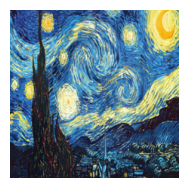

torch.Size([1, 3, 224, 224])

In [4]:
def load_style_image():
    import PIL.Image
    import numpy as np

    image = PIL.Image.open('./datas/style.jpg')
    image = image.resize((224, 224))
    image = np.array(image) / 255
    image = image.transpose(2, 0, 1)[np.newaxis, :]

    image = torch.FloatTensor(image)

    return image


image_style = load_style_image()

show(image_style)

image_style.shape

In [5]:
from transformers import PreTrainedModel, PretrainedConfig


class GEN(PreTrainedModel):
    config_class = PretrainedConfig

    def __init__(self, config):
        super().__init__(config)

        self.encoder = torch.nn.Sequential(
            torch.nn.ReflectionPad2d(padding=4),
            torch.nn.Conv2d(3, 32, kernel_size=9, stride=1, padding=0),
            torch.nn.InstanceNorm2d(32, affine=True),
            torch.nn.ReLU(),
            torch.nn.ReflectionPad2d(padding=1),
            torch.nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=0),
            torch.nn.InstanceNorm2d(64, affine=True),
            torch.nn.ReLU(),
            torch.nn.ReflectionPad2d(padding=1),
            torch.nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=0),
            torch.nn.InstanceNorm2d(128, affine=True),
            torch.nn.ReLU(),
        )

        self.middle = torch.nn.ModuleList([
            torch.nn.Sequential(
                torch.nn.ReflectionPad2d(padding=1),
                torch.nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=0),
                torch.nn.InstanceNorm2d(128, affine=True),
                torch.nn.ReLU(),
                torch.nn.ReflectionPad2d(padding=1),
                torch.nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=0),
                torch.nn.InstanceNorm2d(128, affine=True),
            ) for _ in range(5)
        ])

        self.decoder = torch.nn.Sequential(
            torch.nn.UpsamplingNearest2d(scale_factor=2),
            torch.nn.ReflectionPad2d(padding=1),
            torch.nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=0),
            torch.nn.InstanceNorm2d(64, affine=True),
            torch.nn.ReLU(),
            torch.nn.UpsamplingNearest2d(scale_factor=2),
            torch.nn.ReflectionPad2d(padding=1),
            torch.nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=0),
            torch.nn.InstanceNorm2d(32, affine=True),
            torch.nn.ReLU(),
            torch.nn.ReflectionPad2d(padding=4),
            torch.nn.Conv2d(32, 3, kernel_size=9, stride=1, padding=0),
        )

    def forward(self, data):
        data = self.encoder(data)

        for i in self.middle:
            data = data + i(data)

        data = self.decoder(data)

        return data


gen = GEN(PretrainedConfig())

gen(torch.randn(2, 3, 224, 224)).shape

torch.Size([2, 3, 224, 224])

In [6]:
import torchvision

cnn = torchvision.models.vgg16(weights='IMAGENET1K_V1').features[:19]
cnn.eval()

len(cnn)

19

In [7]:
def get_feature_content(image):
    for i, layer in enumerate(cnn):
        image = layer(image)

        if i == 6:
            return image


get_feature_content(torch.randn(2, 3, 224, 224)).shape

torch.Size([2, 128, 112, 112])

In [8]:
def get_feature_style(image):
    feature = []
    for i, layer in enumerate(cnn):
        image = layer(image)

        if i in [1, 6, 11, 18]:
            fenmu = image.shape[1] * image.shape[2] * image.shape[3]

            data = image.flatten(start_dim=2)
            data = torch.matmul(data, data.permute(0, 2, 1))

            data = data / fenmu

            feature.append(data)

    return feature


target_style = get_feature_style(image_style)

for i in target_style:
    print(i.shape)

torch.Size([1, 64, 64])
torch.Size([1, 128, 128])
torch.Size([1, 256, 256])
torch.Size([1, 512, 512])


In [9]:
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(gen.parameters(), lr=2e-4)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

cnn.to(device)
gen.to(device)
target_style = [i.to(device).detach() for i in target_style]

cnn.eval()
gen.train()

device

'cuda'

/root/anaconda3/envs/pt39/lib/python3.9/site-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([1, 64, 64])) that is different to the input size (torch.Size([4, 64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/root/anaconda3/envs/pt39/lib/python3.9/site-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([1, 128, 128])) that is different to the input size (torch.Size([4, 128, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/root/anaconda3/envs/pt39/lib/python3.9/site-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([1, 256, 256])) that is different to the input size (torch.Size([4, 256, 256])). This will likely lead to incorrect results due

0 61286.00239753723 40554.35510963434


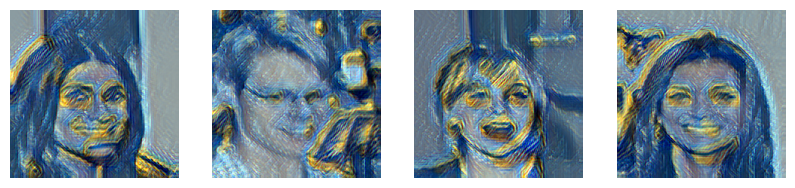

1 59388.935565948486 28036.28603942343


2 58443.14098358154 28845.44528569677


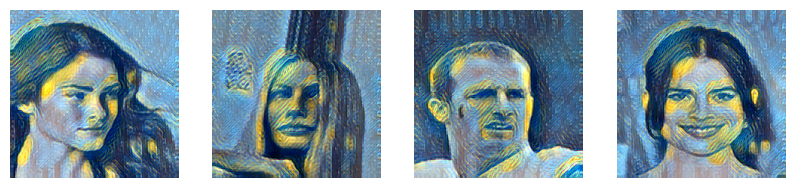

3 56937.77799606323 25068.79127395223


4 54441.70832633972 25250.956241507083


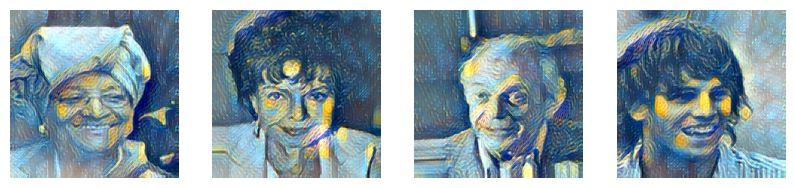

5 54741.477966308594 22246.82702944847


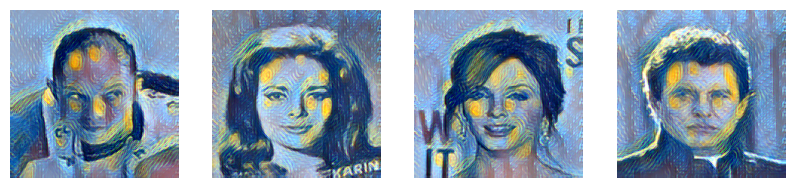

6 50437.73651123047 25980.76434878749


7 51225.73971748352 23861.3256442477


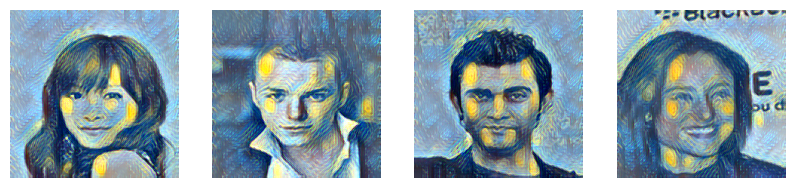

8 49840.739369392395 23475.499801861588


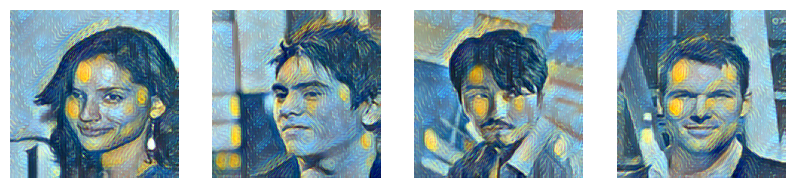

9 50214.80917930603 24632.695385662373


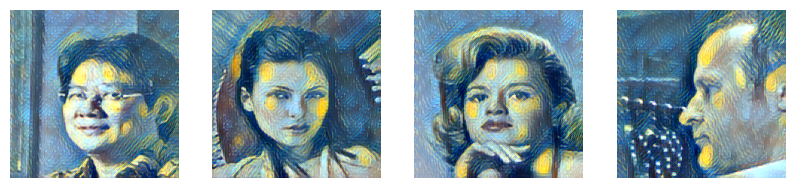

10 48801.60093307495 24526.968900318025


11 49282.84287452698 21400.674086180516


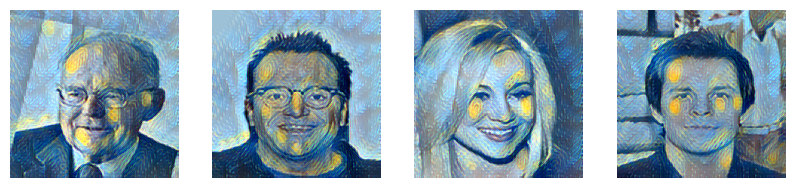

12 48346.149921417236 20653.928913816344


13 50624.5493888855 20623.197087843437


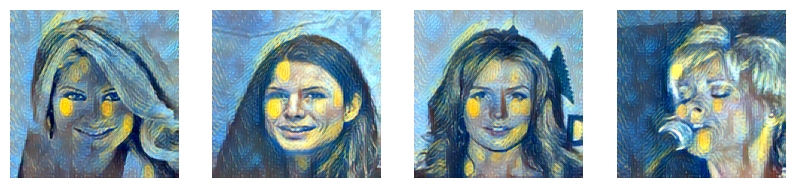

14 47274.44350719452 20076.99777095695


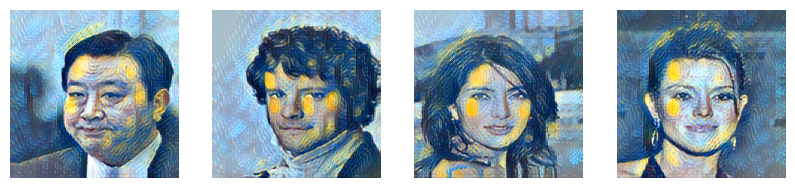

15 48741.47176742554 20898.78762490116


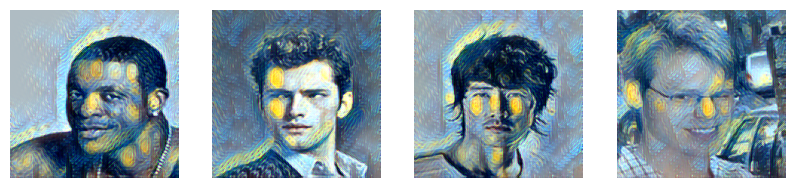

16 48522.26376533508 21352.87104465533


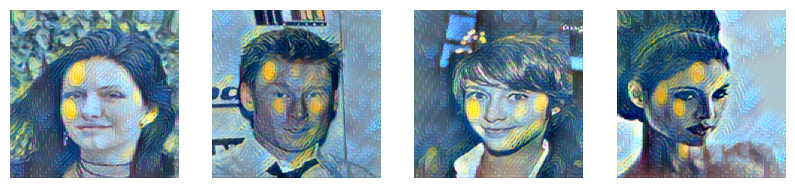

17 44914.376735687256 19352.05546033103


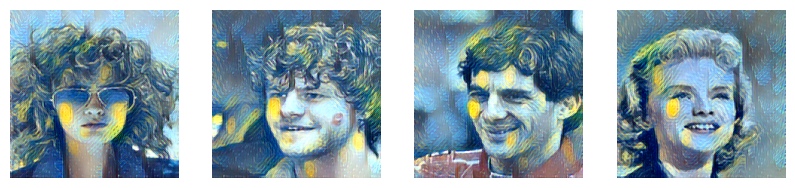

18 48276.57341957092 19754.559161810903


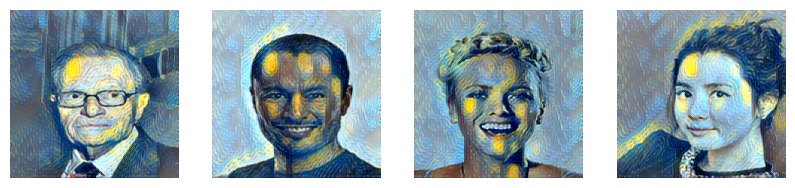

19 45067.620277404785 19139.61568789091


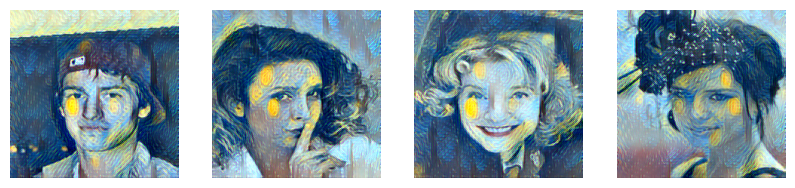

In [10]:
def train():
    for epoch in range(20):

        for i, image in enumerate(loader):
            image = image.to(device)

            with torch.no_grad():
                target_content = get_feature_content(image)

            image_gen = gen(image)

            feature_content = get_feature_content(image_gen)
            feature_style = get_feature_style(image_gen)

            loss_style = sum(
                [criterion(i, j) for i, j in zip(feature_style, target_style)])
            loss_content = criterion(feature_content, target_content)

            loss = 1e5 * loss_content + 1e10 * loss_style
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        if epoch % 1 == 0:
            print(epoch, 1e5 * loss_content.item(), 1e10 * loss_style.item())
            show(image_gen.clip(0, 1))


local_training = True

if local_training:
    train()

In [11]:
if local_training:
    #保存训练好的模型到hub
    gen.to('cpu').push_to_hub(
        repo_id='lansinuote/gen.8.style_transfer',
        use_auth_token=open('/root/hub_token.txt').read().strip())

Upload 1 LFS files:   0%|          | 0/1 [00:00<?, ?it/s]

pytorch_model.bin:   0%|          | 0.00/6.73M [00:00<?, ?B/s]

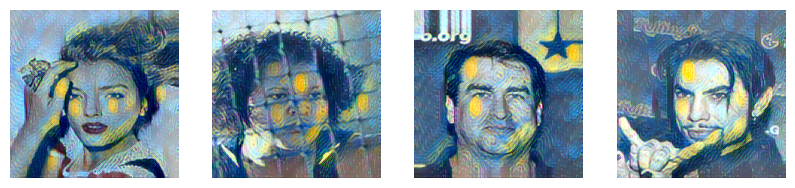

In [12]:
#加载训练好的模型
gen = GEN.from_pretrained('lansinuote/gen.8.style_transfer')

with torch.no_grad():
    pred = gen(next(iter(loader))).clip(0, 1)
    
show(pred)